In [4]:
import numpy as np
import pandas as pd
from pandas import *
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.metrics import accuracy_score
from sklearn import metrics
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier  
from sklearn.metrics import roc_auc_score
from mlxtend.feature_selection import SequentialFeatureSelector
import warnings
warnings.filterwarnings('ignore')

# Importing the Dataset1

In [56]:
gpuread = pd.read_csv("sgemm_product.csv")
gpuread.dropna(inplace=True)

df_run = DataFrame(gpuread,columns=['Run1 (ms)','Run2 (ms)','Run3 (ms)','Run4 (ms)'])

gpuread['Avg_Run'] = df_run.mean(axis =1)
gpuread['log_avg_run'] = np.log(gpuread.Avg_Run).round(3)
gpuread['gpuruntime_class'] = np.where(gpuread['log_avg_run']>=4.24, 1, 0)
gpuread['gpuruntime_class'] = gpuread['gpuruntime_class'].astype('category')

gpuread=gpuread.sample(40000,random_state=42)

train_data, test_data = train_test_split(gpuread, test_size = 0.3, random_state = 20)
y_train=train_data['gpuruntime_class']
y_test=test_data['gpuruntime_class']
x_train=train_data[['MWG','NWG','KWG','MDIMC','NDIMC','MDIMA','NDIMB','KWI','VWM','VWN','STRM','STRN','SA','SB']]
x_test=test_data[['MWG','NWG','KWG','MDIMC','NDIMC','MDIMA','NDIMB','KWI','VWM','VWN','STRM','STRN','SA','SB']]

# Feature Scaling

In [57]:
Scale_Train = preprocessing.StandardScaler().fit(x_train[['MWG','NWG','KWG','MDIMC','NDIMC','MDIMA','NDIMB','KWI','VWM','VWN','STRM','STRN','SA','SB']])
X_train = Scale_Train.transform(x_train[['MWG','NWG','KWG','MDIMC','NDIMC','MDIMA','NDIMB','KWI','VWM','VWN','STRM','STRN','SA','SB']])

Scale_Test = preprocessing.StandardScaler().fit(x_test[['MWG','NWG','KWG','MDIMC','NDIMC','MDIMA','NDIMB','KWI','VWM','VWN','STRM','STRN','SA','SB']])
X_test = Scale_Test.transform(x_test[['MWG','NWG','KWG','MDIMC','NDIMC','MDIMA','NDIMB','KWI','VWM','VWN','STRM','STRN','SA','SB']])

# K-Means Clustering Algorithm 

[[9600 4344]
 [6314 7742]]
0.6193571428571428


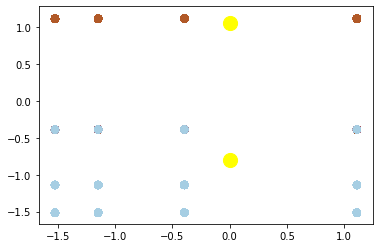

In [58]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2) 
kmeans.fit(X_train)
y=np.array(y_train)
y=y.astype(float)
j = 0
predict2=[]
for i in range(len(X_train)):
    predict_gpu = np.array(X_train[i].astype(float))
    predict_gpu = predict_gpu.reshape(-1, len(predict_gpu))
    predict2.append(kmeans.predict(predict_gpu))
    if predict2[i] == y[i]:
        j += 1

yp=kmeans.predict(X_train)
plt.scatter(X_train[:, 0], X_train[:, 1], c=yp, s=50, cmap=plt.cm.Paired)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='Yellow', s=200)
print(confusion_matrix(y,yp))
print(accuracy_score(y,yp))

[[4121 1815]
 [2746 3318]]
0.6199166666666667


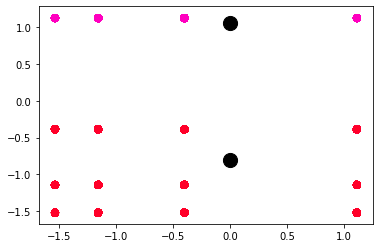

In [59]:
y=np.array(y_test)
y=y.astype(float)
k = 0
predict3=[]
for i in range(len(X_test)):
    predict_gpu1 = np.array(X_test[i].astype(float))
    predict_gpu1 = predict_gpu1.reshape(-1, len(predict_gpu1))
    predict3.append(kmeans.predict(predict_gpu1))
    if predict3[i] == y[i]:
        k += 1

yp2=kmeans.predict(X_test)
plt.scatter(X_test[:, 0], X_test[:, 1], c=yp2, s=50, cmap='gist_rainbow')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='Black', s=200)
print(confusion_matrix(y,yp2))
print(accuracy_score(y,yp2))

# Feature Selection - Forward Selection

In [27]:
feature_selector = SequentialFeatureSelector(RandomForestClassifier(n_jobs=-1),  
           k_features=12,
           forward=True,
           verbose=2,
           scoring='roc_auc',
           cv=2)
features = feature_selector.fit(X_train,y_train)
filtered_features= x_train.columns[list(features.k_feature_idx_)]  
filtered_features

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    7.9s finished

[2020-04-24 20:15:57] Features: 1/12 -- score: 0.7279653923442367[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    4.8s finished

[2020-04-24 20:16:02] Features: 2/12 -- score: 0.7988391079563395[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    4.5s finished

[2020-04-24 20:16:07] Features: 3/12 -- score: 0.8665376452145683[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

Index(['MWG', 'NWG', 'KWG', 'MDIMC', 'NDIMC', 'MDIMA', 'KWI', 'VWM', 'VWN',
       'STRM', 'SA', 'SB'],
      dtype='object')

# Principal Component Analysis (PCA)

In [28]:
x=x_train[['MWG','NWG','KWG','MDIMC','NDIMC','MDIMA','NDIMB','KWI','VWM','VWN','STRM','STRN','SA','SB']]
xt=x_test[['MWG','NWG','KWG','MDIMC','NDIMC','MDIMA','NDIMB','KWI','VWM','VWN','STRM','STRN','SA','SB']]
x= preprocessing.StandardScaler().fit_transform(x)
xt= preprocessing.StandardScaler().fit_transform(xt)
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca_train =pca.fit_transform(x)
pca_test=pca.fit_transform(xt)

# Independent Component Analysis (ICA)

In [29]:
from sklearn.decomposition import FastICA
ica = FastICA(n_components=6)
ica_train =ica.fit_transform(x)
ica_test=ica.fit_transform(xt)

# Randomized Projection

In [30]:
from sklearn.random_projection import GaussianRandomProjection
rca = GaussianRandomProjection(n_components=6, eps=0.1, random_state=42)
rca_train =rca.fit_transform(x)
rca_test=rca.fit_transform(xt)

# K - Means Clustering using PCA

0.48996428571428574


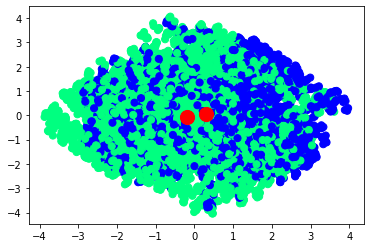

In [60]:
kmeans.fit(pca_train)
y=np.array(y_train)
y=y.astype(float)
l = 0
predict4=[]
for i in range(len(pca_train)):
    predict_gpu4 = np.array(pca_train[i].astype(float))
    predict_gpu4 = predict_gpu4.reshape(-1, len(predict_gpu4))
    predict4.append(kmeans.predict(predict_gpu4))
    if predict4[i] == y[i]:
        l += 1
yp=kmeans.predict(pca_train)
plt.scatter(pca_train[:, 0], pca_train[:, 1], c=yp, s=50, cmap='winter')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200)
print(accuracy_score(y,yp))

0.4800833333333333


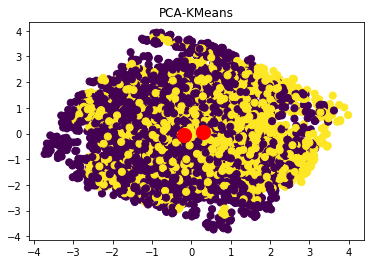

In [61]:
y=np.array(y_test)
y=y.astype(float)
m = 0
predict5=[]
for i in range(len(pca_test)):
    predict_gpu5 = np.array(pca_test[i].astype(float))
    predict_gpu5 = predict_gpu5.reshape(-1, len(predict_gpu5))
    predict5.append(kmeans.predict(predict_gpu5))
    if predict5[i] == y[i]:
        m += 1
yp=kmeans.predict(pca_test)
plt.scatter(pca_test[:, 0], pca_test[:, 1], c=yp, s=50, cmap='viridis_r')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200)
plt.title('PCA-KMeans')
print(accuracy_score(y,yp))

# K - Means Clustering using ICA

0.48946428571428574


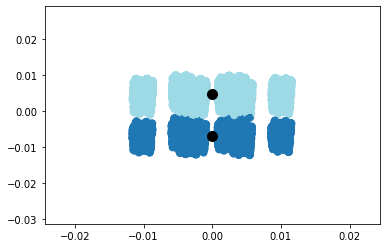

In [62]:
kmeans.fit(ica_train)
y=np.array(y_train)
y=y.astype(float)
n = 0
predict6=[]
for i in range(len(ica_train)):
    predict_gpu6 = np.array(ica_train[i].astype(float))
    predict_gpu6 = predict_gpu6.reshape(-1, len(predict_gpu6))
    predict6.append(kmeans.predict(predict_gpu6))
    if predict6[i] == y[i]:
        n += 1
yp=kmeans.predict(ica_train)
plt.scatter(ica_train[:, 0], ica_train[:, 1], c=yp, s=50, cmap='tab20')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='Black', s=100)
print(accuracy_score(y,yp))

0.43416666666666665


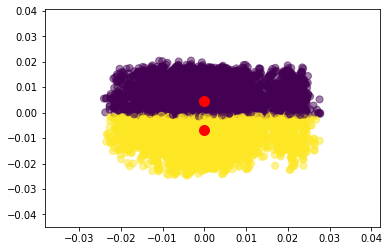

In [63]:
y=np.array(y_test)
y=y.astype(float)
p = 0
predict7=[]
for i in range(len(ica_test)):
    predict_gpu7 = np.array(ica_test[i].astype(float))
    predict_gpu7 = predict_gpu7.reshape(-1, len(predict_gpu7))
    predict7.append(kmeans.predict(predict_gpu7))
    if predict7[i] == y[i]:
        p += 1
yp=kmeans.predict(ica_test)
plt.scatter(ica_test[:, 0], ica_test[:, 1], c=yp, s=50, cmap='viridis_r', alpha=0.5)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=100)
print(accuracy_score(y,yp))

# K-Means Clustering using RCA

0.4632142857142857


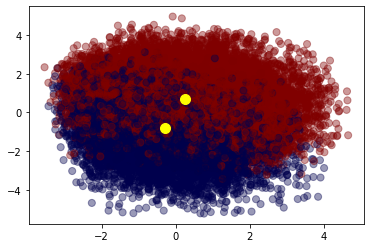

In [64]:
kmeans.fit(rca_train)
y=np.array(y_train)
y=y.astype(float)
q = 0
predict8=[]
for i in range(len(rca_train)):
    predict_gpu8 = np.array(rca_train[i].astype(float))
    predict_gpu8 = predict_gpu8.reshape(-1, len(predict_gpu8))
    predict8.append(kmeans.predict(predict_gpu8))
    if predict8[i] == y[i]:
        q += 1
yp=kmeans.predict(rca_train)
plt.scatter(rca_train[:, 0], rca_train[:, 1], c=yp, s=50, cmap='seismic',alpha=0.4)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='Yellow', s=100)
print(accuracy_score(y,yp))

0.4725


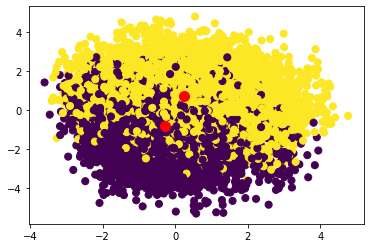

In [65]:
y=np.array(y_test)
y=y.astype(float)
r = 0
predict9=[]
for i in range(len(rca_test)):
    predict_gpu9 = np.array(rca_test[i].astype(float))
    predict_gpu9 = predict_gpu9.reshape(-1, len(predict_gpu9))
    predict9.append(kmeans.predict(predict_gpu9))
    if predict9[i] == y[i]:
        r += 1
yp=kmeans.predict(rca_test)
plt.scatter(rca_test[:, 0], rca_test[:, 1], c=yp, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=100)
print(accuracy_score(y,yp))

# Neural Networks with PCA

In [38]:
input_shape=6
classifier = Sequential()
classifier.add(Dense(10, kernel_initializer='uniform', activation= 'selu', input_shape =(input_shape,)))
classifier.add(Dense(5, kernel_initializer='uniform', activation= 'selu'))
classifier.add(Dense(3, kernel_initializer='uniform', activation= 'selu'))
classifier.add(Dense(1, kernel_initializer= 'uniform', activation= 'sigmoid'))
classifier.compile(optimizer= 'Adam',loss='binary_crossentropy', metrics=['accuracy'])
hist = classifier.fit(pca_train, y_train, batch_size = 10, epochs = 10)
y_predict = classifier.predict(pca_test)
y_predict = np.where(y_predict > 0.5,1,0)
y_test_array=np.array(y_test)
y_test_array= y_test_array.astype(float)
print(confusion_matrix(y_test_array,y_predict))  
print(classification_report(y_test_array,y_predict))
acc_score=accuracy_score(y_test_array,y_predict)
print(acc_score)
y_predict_train=classifier.predict(pca_train)
y_predict_train = np.where(y_predict_train > 0.5,1,0)
y_train_array=np.array(y_train)
y_train_array= y_train_array.astype(float)
print(confusion_matrix(y_train_array,y_predict_train))  
print(classification_report(y_train_array,y_predict_train))
acc_score1=accuracy_score(y_train_array,y_predict_train)
print(acc_score1)

Epoch 1/10
28000/28000 [==============================] - 6s 216us/step - loss: 0.5863 - accuracy: 0.6994
Epoch 2/10
28000/28000 [==============================] - 6s 201us/step - loss: 0.5764 - accuracy: 0.7028
Epoch 3/10
28000/28000 [==============================] - 6s 214us/step - loss: 0.5687 - accuracy: 0.7056
Epoch 4/10
28000/28000 [==============================] - 6s 212us/step - loss: 0.5551 - accuracy: 0.7113
Epoch 5/10
28000/28000 [==============================] - 6s 208us/step - loss: 0.5494 - accuracy: 0.7121
Epoch 6/10
28000/28000 [==============================] - 5s 184us/step - loss: 0.5451 - accuracy: 0.7169
Epoch 7/10
28000/28000 [==============================] - 5s 173us/step - loss: 0.5402 - accuracy: 0.7157
Epoch 8/10
28000/28000 [==============================] - 6s 213us/step - loss: 0.5331 - accuracy: 0.7198
Epoch 9/10
28000/28000 [==============================] - 6s 209us/step - loss: 0.5269 - accuracy: 0.7249
Epoch 10/10
28000/28000 [=====================

# Train and Test Accuracy for various Models of K-Means

Text(0.5, 1.0, 'Train and Test Accuracy for various Models of K-Means')

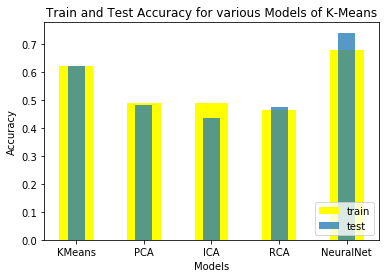

In [67]:
train_accuracy = [0.6193,0.4899,0.4894,0.4632,0.6786]
test_accuracy=[0.6199,0.4800,0.4341,0.4725,0.7395]
Models =['KMeans','PCA','ICA','RCA','NeuralNet']
plt.bar(Models,train_accuracy,label='train',width=0.5,color='Yellow')
plt.bar(Models,test_accuracy,label='test',width=0.25,alpha = 0.75)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.title("Train and Test Accuracy for various Models of K-Means")

# Expectation Maximization

[[ 1597 12347]
 [ 3781 10275]]
0.424


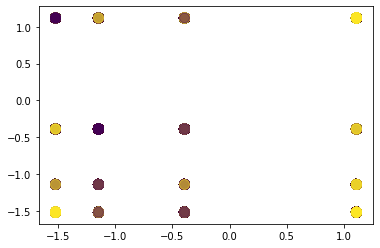

In [41]:
from sklearn.mixture import GaussianMixture
y=np.array(y_train)
y=y.astype(float)
em = GaussianMixture(n_components=2,random_state=0,covariance_type='tied')
em.fit(X_train)
em_pred = em.predict(X_train)
em_probs = em.predict_proba(X_train)
print(confusion_matrix(y,em_pred))
print(accuracy_score(y,em_pred))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y, s=100, cmap='viridis',alpha = 0.6)

[[ 700 5236]
 [1579 4485]]
0.4320833333333333


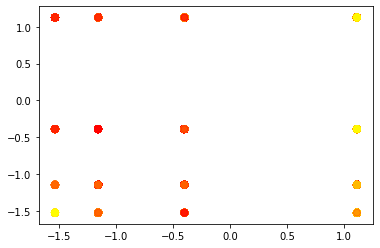

In [42]:
y=np.array(y_test)
y=y.astype(float)
em_predict = em.predict(X_test)
em_prob = em.predict_proba(X_test)
print(confusion_matrix(y,em_predict))
print(accuracy_score(y,em_predict))
plt.scatter(X_test[:, 0], X_test[:, 1], c=y, s=50, cmap='autumn',alpha =0.4)

# Analysis of PCA data

[[ 1144 12800]
 [ 4698  9358]]
0.37507142857142856


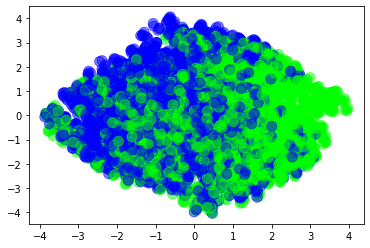

In [43]:
em = GaussianMixture(n_components=2,random_state=0,covariance_type='tied')
y=np.array(y_train)
y=y.astype(float)
em.fit(pca_train)
em_pred = em.predict(pca_train)
em_probs = em.predict_proba(pca_train)
print(confusion_matrix(y,em_pred))
print(accuracy_score(y,em_pred))
plt.scatter(pca_train[:, 0], pca_train[:, 1], c=y, s=100, cmap='brg',alpha = 0.5)

[[ 543 5393]
 [1867 4197]]
0.395


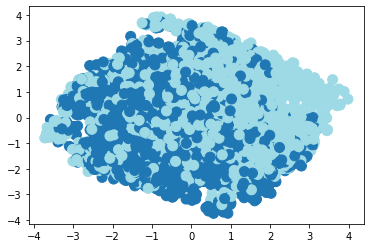

In [44]:
y=np.array(y_test)
y=y.astype(float)
em_pred = em.predict(pca_test)
em_probs = em.predict_proba(pca_test)
print(confusion_matrix(y,em_pred))
print(accuracy_score(y,em_pred))
plt.scatter(pca_test[:, 0], pca_test[:, 1], c=y, s=100, cmap='tab20')

# Analysis of ICA data

[[11099  2845]
 [12178  1878]]
0.4634642857142857


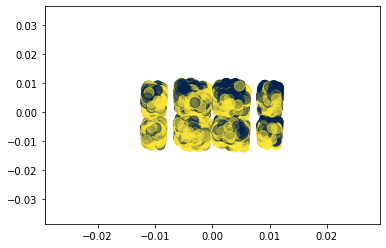

In [45]:
em = GaussianMixture(n_components=2,random_state=0,covariance_type='tied')
y=np.array(y_train)
y=y.astype(float)
em.fit(ica_train)
em_pred = em.predict(ica_train)
em_probs = em.predict_proba(ica_train)
print(confusion_matrix(y,em_pred))
print(accuracy_score(y,em_pred))
plt.scatter(ica_train[:, 0], ica_train[:, 1], c=y, s=100, cmap='cividis', alpha = 0.5)

[[4387 1549]
 [4372 1692]]
0.5065833333333334


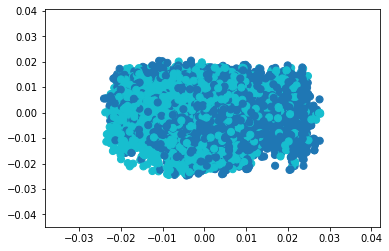

In [46]:
y=np.array(y_test)
y=y.astype(float)
em_pred = em.predict(ica_test)
em_probs = em.predict_proba(ica_test)
print(confusion_matrix(y,em_pred))
print(accuracy_score(y,em_pred))
plt.scatter(ica_test[:, 0], ica_test[:, 1], c=y, s=50, cmap='tab10_r')

# Analysis of RCA data

[[ 3740 10204]
 [ 3755 10301]]
0.5014642857142857


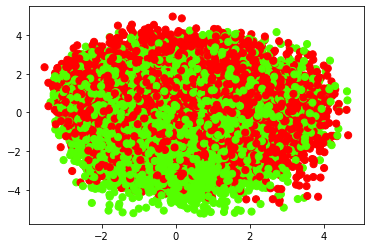

In [47]:
em = GaussianMixture(n_components=2,random_state=0,covariance_type='tied')
y=np.array(y_train)
y=y.astype(float)
em.fit(rca_train)
em_pred = em.predict(rca_train)
em_probs = em.predict_proba(rca_train)
print(confusion_matrix(y,em_pred))
print(accuracy_score(y,em_pred))
plt.scatter(rca_train[:, 0], rca_train[:, 1], c=y, s=50, cmap='prism')

[[1625 4311]
 [1560 4504]]
0.51075


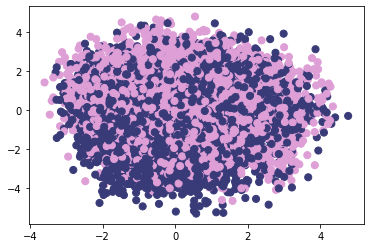

In [48]:
y=np.array(y_test)
y=y.astype(float)
em_pred = em.predict(rca_test)
em_probs = em.predict_proba(rca_test)
print(confusion_matrix(y,em_pred))
print(accuracy_score(y,em_pred))
plt.scatter(rca_test[:, 0], rca_test[:, 1], c=y, s=50, cmap='tab20b_r')

# Train and Test Accuracy for various Models for Expectation Maximization

Text(0.5, 1.0, 'Train and Test Accuracy for various Models for Expectation Maximization')

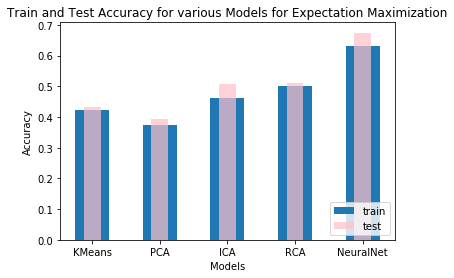

In [68]:
train_accuracy = [0.424,0.375,0.4634,0.5014,0.6326]
test_accuracy=[0.432,0.395,0.5065,0.5107,0.6744]
Models =['KMeans','PCA','ICA','RCA','NeuralNet']
plt.bar(Models,train_accuracy,label='train',width=0.5)
plt.bar(Models,test_accuracy,label='test',width=0.25,color = 'Pink',alpha = 0.7)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.title("Train and Test Accuracy for various Models for Expectation Maximization")

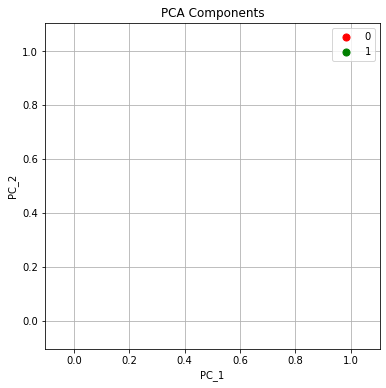

In [66]:
principalDf = pd.DataFrame(data = pca_train
             , columns = ['PC1', 'PC2','PC3','PC4','PC5','PC6'])
finalDf=pd.concat([principalDf, y_train], axis = 1)
finalDf=finalDf.fillna(1)
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC_1')
ax.set_ylabel('PC_2')
ax.set_title('PCA Components')
targets = ['0','1']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['gpuruntime_class'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

# Neural Network Analysis with features from KMeans & Expectation Maximization

In [51]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)
kmeans.fit(pca_train)
kmeans=kmeans.predict(pca_train)
em.fit(pca_train)
probs_em=em.predict_proba(pca_train)
new = pd.DataFrame()
dataframe1 = pd.DataFrame({"KM_Pred": kmeans,"EM_Prob": probs_em[:,0],"y": y_train})
new=new.append(dataframe1)

In [52]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(pca_test)
kmeans1=kmeans.predict(pca_test)
em.fit(pca_test)
probs_em1=em.predict_proba(pca_test)
new1 = pd.DataFrame()
dataframe2 = pd.DataFrame({"KM_Pred": kmeans1,"EM_Prob": probs_em1[:,0],"y": y_test})
new1 = new.append(dataframe2)

In [53]:
trainy=new.drop(columns=['KM_Pred','EM_Prob'],axis=1)
trainy=np.array(trainy)
trainy=trainy.astype(float)
testy=new1.drop(columns=['KM_Pred','EM_Prob'],axis=1)
testy=np.array(testy)
testy=testy.astype(float)

In [54]:
trainx=new.drop(columns=['y'],axis=1)
trainx=np.array(trainx)
trainx=trainx.astype(float)
testx=new1.drop(columns=['y'],axis=1)
testx=np.array(testx)
testx=testx.astype(float)

In [55]:
input_shape1=2
classifier = Sequential()
classifier.add(Dense(10, kernel_initializer='uniform', activation= 'selu', input_shape =(input_shape1,)))
classifier.add(Dense(5, kernel_initializer='uniform', activation= 'selu'))
classifier.add(Dense(3, kernel_initializer='uniform', activation= 'selu'))
classifier.add(Dense(1, kernel_initializer= 'uniform', activation= 'sigmoid'))
classifier.compile(optimizer= 'Adam',loss='binary_crossentropy', metrics=['accuracy'])
hist = classifier.fit(trainx, trainy, batch_size = 10, epochs = 10)
y_predict = classifier.predict(testx)
y_predict = np.where(y_predict > 0.5,1,0)
y_test_array= np.array(testy)
y_test_array= y_test_array.astype(float) 
print(classification_report(y_test_array,y_predict))
acc_score=accuracy_score(y_test_array,y_predict)
print(acc_score)
y_predict_train=classifier.predict(trainx)
y_predict_train = np.where(y_predict_train > 0.5,1,0)
y_train_array=np.array(trainy)
y_train_array= y_train_array.astype(float) 
print(classification_report(y_train_array,y_predict_train))
acc_score1=accuracy_score(y_train_array,y_predict_train)
print(acc_score1)

Epoch 1/10
28000/28000 [==============================] - 6s 203us/step - loss: 0.6209 - accuracy: 0.6650
Epoch 2/10
28000/28000 [==============================] - 6s 214us/step - loss: 0.6143 - accuracy: 0.6721
Epoch 3/10
28000/28000 [==============================] - 6s 208us/step - loss: 0.6138 - accuracy: 0.6727
Epoch 4/10
28000/28000 [==============================] - 6s 212us/step - loss: 0.6130 - accuracy: 0.6736
Epoch 5/10
28000/28000 [==============================] - 6s 205us/step - loss: 0.6121 - accuracy: 0.6739
Epoch 6/10
28000/28000 [==============================] - 6s 208us/step - loss: 0.6118 - accuracy: 0.6734
Epoch 7/10
28000/28000 [==============================] - 6s 212us/step - loss: 0.6116 - accuracy: 0.6743
Epoch 8/10
28000/28000 [==============================] - 6s 203us/step - loss: 0.6114 - accuracy: 0.6736
Epoch 9/10
28000/28000 [==============================] - 6s 222us/step - loss: 0.6115 - accuracy: 0.6734
Epoch 10/10
28000/28000 [=====================